## Vesuvius Challenge - Ink Detection Training Notebook

### Setup

In [86]:
# # Pretrained weights
# # ref - https://github.com/kenshohara/3D-ResNets-PyTorch
# !pip install gdown
# !gdown 1Nb4abvIkkp_ydPFA9sNPT1WakoVKA8Fa

# # Utility packages for reading and visualizing volumes
# !pip install zarr imageio-ffmpeg

# # save model checkpoints
# !mkdir ./ckpts

# !kaggle datasets download -d samfc10/vesuvius-zarr-files

In [87]:
import os
import gc
import sys
import zarr
import random
import imageio
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import os,cv2
import gc
import sys
import random
from glob import glob
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda import amp
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
from IPython.display import Video

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda import amp
from torch.utils.data import Dataset, DataLoader

# sys.path.append("/kaggle/input/resnet3d")
ROOT_DIR = '/home/fummicc1/codes/competitions/kaggle-ink-detection/'
sys.path.append(ROOT_DIR)
from resnet3d import generate_model

### Config

In [88]:
DATA_DIR = ROOT_DIR
# DATA_DIR = "/kaggle/input/vesuvius-zarr-files/"
LR = 1e-4
EPOCHS = 20
BATCH_SIZE = 32
NUM_WORKERS = 8
CROP_SIZE = 160
Z_START = 12
Z_DIMS = 40
TRAIN_FRAGMENTS = ["2", "3"]
TEST_FRAGMENT = "1"
MODEL_DEPTH = 34
MAX_PIXEL_VALUE = 2 ** 16 - 1
RESIZE_HEIGHT = 3200
COMP_DATASET_PATH = "/home/fummicc1/codes/competitions/kaggle-ink-detection/"

### Load data

In [89]:
def resize(img):
    current_height, current_width = img.shape[:2]
    aspect_ratio = current_width / current_height
    new_height = RESIZE_HEIGHT
    new_width = int(new_height * aspect_ratio)
    new_size = (new_width, new_height)
    # (W, H)の順で渡すが結果は(H, W)になっている
    img = cv2.resize(img, new_size)
    return img

In [90]:
def load_mask(split, index):
    img = cv2.imread(f"{DATA_DIR}/{split}/{index}/mask.png", 0) // 255    
    img = resize(img)    
    return img

def load_labels(split, index):
    img = cv2.imread(f"{DATA_DIR}/{split}/{index}/inklabels.png", 0) // 255
    img = resize(img)
    return img

In [91]:
def calculate_mean_std(volume):
    mean_0 = np.mean(volume, axis=0)
    mean_1 = np.mean(mean_0, axis=0)
    std_0 = np.std(volume, axis=0)
    std_1 = np.std(std_0, axis=0)
    return mean_1, std_1


In [92]:
def read_image(mode, fragment_id):
    images = []

    # idxs = range(65)
    start = 0
    end = 65
    idxs = range(start, end)

    for i in tqdm(idxs):
        image = cv2.imread(COMP_DATASET_PATH + f"{mode}/{fragment_id}/surface_volume/{i:02}.tif", -1)
        # image = cv2.imread(CFG.comp_dataset_path + f"{mode}/{fragment_id}/surface_volume/{i:02}.tif", 0)
        
        # print(image.max())
        image = resize(image).astype(np.uint16)     
        # print(image.max())

        # pad0 = (CROP_SIZE - image.shape[0] % CROP_SIZE)
        # pad1 = (CROP_SIZE - image.shape[1] % CROP_SIZE)

        # image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)
        # print(image.max())
        images.append(image)
    images = np.stack(images, axis=2, dtype=np.uint16)
    # print(images.max())
    return images

In [93]:
FRAGMENTS_ZARR = {
    "1" : zarr.open(f"{ROOT_DIR}train-1.zarr", mode="rw"),
    "2" : zarr.open(f"{ROOT_DIR}/train-2.zarr", mode="rw"),
    "3" : zarr.open(f"{ROOT_DIR}/train-3.zarr", mode="rw")
}


In [94]:

for key in ["1", "2", "3"]:
    FRAGMENTS_ZARR[key]["surface_volume"] = read_image("train", key)
    FRAGMENTS_ZARR[key]["mask"] = load_mask("train", key)
    FRAGMENTS_ZARR[key]["truth"] = load_labels("train", key)
    
FRAGMENTS_SHAPE = {k : v.surface_volume.shape[:-1] for k, v in FRAGMENTS_ZARR.items()}

100%|██████████| 65/65 [00:03<00:00, 16.26it/s]


In [95]:

ALL_MEAN_STD = {}
for key in ["1", "2", "3"]:
    img = FRAGMENTS_ZARR["1"]["surface_volume"][:, :, Z_START:Z_START+Z_DIMS]

    ALL_MEAN_STD[key] = calculate_mean_std(img)
    

In [96]:
mean, std = ALL_MEAN_STD["1"]
mean, std

(array([14744.41292134, 15033.20581503, 15378.60221237, 15753.93886086,
        16109.66528422, 16369.55195745, 16438.32963725, 16222.16794066,
        15666.72035013, 14798.78606023, 13742.22449848, 12686.93735341,
        11817.86990543, 11249.12849861, 11001.03554621, 11017.89195707,
        11208.52217551, 11483.2586899 , 11775.52387866, 12046.24169508,
        12277.59524495, 12465.56811843, 12613.17306616, 12726.64386641,
        12812.68786515, 12877.25552967, 12925.52406692, 12962.09812614,
        12990.19989306, 13012.13834217, 13029.13715556, 13041.98572008,
        13051.55482765, 13058.7753149 , 13064.49739066, 13069.47356692,
        13073.97167298, 13077.83071414, 13080.90641389, 13083.31846136]),
 array([2168.15091175, 2223.27159147, 2292.5765074 , 2367.54430291,
        2433.92846336, 2476.47050515, 2481.79010373, 2438.81233715,
        2340.67677935, 2188.662406  , 2004.22932311, 1841.25878734,
        1758.15533312, 1748.23590694, 1747.01905867, 1724.68461437,
      

In [97]:
list(FRAGMENTS_ZARR["1"].keys())
np.unique(np.array(FRAGMENTS_ZARR["1"]["truth"]))

array([0, 1], dtype=uint8)

In [98]:
def fetch_fragment_crop(id: str, y1, y2, x1, x2, z1=None, z2=None, key: str = "surface_volume"):
    if key == "surface_volume":
        img = FRAGMENTS_ZARR[id][key][y1:y2, x1:x2, z1:z2]
        return img.astype(np.uint16)
    elif key == "truth":
        img = FRAGMENTS_ZARR[id][key][y1:y2, x1:x2]
        return img.astype(np.uint8)
    print("Error", key)

def fetch_fragment(id: str, z1=None, z2=None, key: str = "surface_volume"):
    if key == "surface_volume":
        img = FRAGMENTS_ZARR[id][key][:, :, z1:z2]
        return img.astype(np.uint16)
    elif key == "truth":
        img = FRAGMENTS_ZARR[id][key]
        return img.astype(np.uint8)

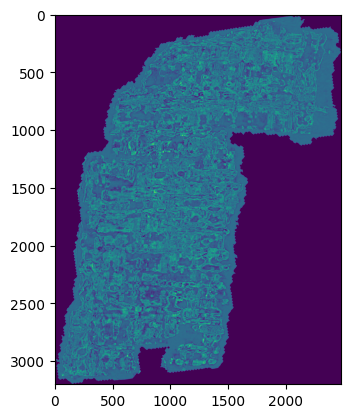

In [99]:
plt.imshow(FRAGMENTS_ZARR["1"]["surface_volume"][:,:,0])

### Visualise input

In [100]:
fragment_id = FRAGMENTS_ZARR["1"]
x, y = 800, 800

fragment_cropped = fetch_fragment_crop("1", y, y+CROP_SIZE, x, x+CROP_SIZE, Z_START, Z_START+Z_DIMS)
imageio.mimwrite("fragment_crop.mp4", fragment_cropped.transpose(2, 0, 1) / 255, "ffmpeg")
Video("fragment_crop.mp4", height=256, width=256)

Lossy conversion from float64 to uint8. Range [0.0, 256.99607843137255]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.24313725490196078, 255.63529411764705]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.42745098039215684, 255.34117647058824]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.027450980392156862, 257.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.1568627450980392, 257.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.49019607843137253, 257.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [3.0509803921568626, 257.0]. Convert image to uint8 prior to saving to suppress this 

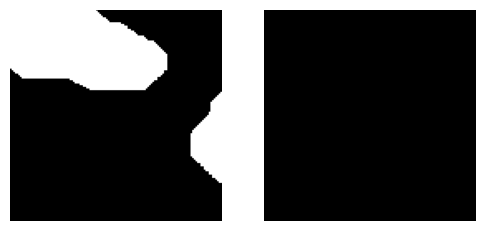

In [101]:
mask_cropped = fragment_id.truth[y:y+CROP_SIZE, x:x+CROP_SIZE]
ir_cropped = fragment_id.infrared[y:y+CROP_SIZE, x:x+CROP_SIZE]

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.imshow(mask_cropped, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(ir_cropped, cmap="gray")
plt.axis("off")
plt.show()

In [102]:
# del fragment_id, fragment_cropped, mask_cropped, ir_cropped
# gc.collect()

### Dataloaders

In [103]:
class VesuviusTrain(Dataset):
    def __init__(self, fragments):
        self.fragments = fragments
        self.xys = []
        
        for fragment_id in fragments:
            H, W = FRAGMENTS_SHAPE[fragment_id]
            for y in range(0, H-CROP_SIZE+1, CROP_SIZE):
                for x in range(0, W-CROP_SIZE+1, CROP_SIZE):
                    self.xys.append((fragment_id, x, y, W, H))
        
    def __getitem__(self, i):
        fragment_id, x1, y1, W, H = self.xys[i]
        z1, z2 = Z_START, Z_START+Z_DIMS
        
        x_offset = random.randint(-32 if x1 != 0 else 0, 32)
        y_offset = random.randint(-32 if y1 != 0 else 0, 32)
        
        x1 += x_offset
        y1 += y_offset
        
        x2 = x1 + CROP_SIZE
        y2 = y1 + CROP_SIZE
        
        if x2 > W:
            x1 -= x_offset
            x2 -= x_offset
            
        if y2 > H:
            y1 -= y_offset
            y2 -= y_offset
            
        # print("x1: ", x1, " x2: ", x2, " y1: ", y1, " y2: ", y2)
        
        frag_crop = fetch_fragment_crop(fragment_id, y1, y2, x1, x2, z1, z2)
        mask_crop = fetch_fragment_crop(fragment_id, y1, y2, x1, x2, key="truth")[:, :, np.newaxis]
        
        performed = A.Compose([
            A.HorizontalFlip(p=0.3), # 水平方向に反転
            A.VerticalFlip(p=0.3), # 水平方向に反転
            A.RandomRotate90(p=0.3),
            A.ShiftScaleRotate(p=0.3),
        ])(image=frag_crop, mask=mask_crop)
        frag_crop = performed["image"]
        mask_crop = performed["mask"]
        
        mean, std = ALL_MEAN_STD[fragment_id]
        frag_crop = (frag_crop - mean) / std
        frag_crop = torch.from_numpy(frag_crop.astype(np.float32)).permute(2, 0, 1)        
        
        mask_crop = torch.from_numpy(mask_crop.astype(np.float32)).permute(2, 0, 1)
        
        assert frag_crop.shape[0] == 40
        
        return {
            "images": frag_crop,
            "labels": mask_crop
        }

    def __len__(self):
        return len(self.xys)

In [104]:
# ALL_MEAN_STD

In [105]:
class VesuviusVal(Dataset):
    def __init__(self, fragment_id):
        self.fragment_id = fragment_id
        self.xys = []
        
        H, W = FRAGMENTS_SHAPE[fragment_id]
        for y in range(0, H-CROP_SIZE+1, CROP_SIZE):
            for x in range(0, W-CROP_SIZE+1, CROP_SIZE):
                self.xys.append((x, y))
                
    def __getitem__(self, i):
        x1, y1 = self.xys[i]
        x2, y2 = x1+CROP_SIZE, y1+CROP_SIZE
        z1, z2 = Z_START, Z_START+Z_DIMS
        
        frag_crop = fetch_fragment_crop(self.fragment_id, y1, y2, x1, x2, z1, z2)
        
        mask_crop = fetch_fragment_crop(self.fragment_id, y1, y2, x1, x2, key="truth")[:, :, np.newaxis]

        mean, std = ALL_MEAN_STD[self.fragment_id]
        
        frag_crop = (frag_crop - mean) / std
        frag_crop = torch.from_numpy(frag_crop.astype(np.float32)).permute(2, 0, 1)        
        
        mask_crop = torch.from_numpy(mask_crop.astype(np.float32)).permute(2, 0, 1)
        
        assert frag_crop.shape[0] == 40
        
        return {
            "images": frag_crop,
            "labels": mask_crop,
            "locations": torch.tensor([x1, y1, x2, y2], dtype=torch.int32)
        }

    def __len__(self):
        return len(self.xys)

In [106]:
def collate_train_fn(batch):
  return {
      'images': torch.stack([x['images'] for x in batch]),
      'labels': torch.stack([x['labels'] for x in batch])
}
  
  
def collate_val_fn(batch):
  return {
      'images': torch.stack([x['images'] for x in batch]),
      'labels': torch.stack([x['labels'] for x in batch]),
      'locations': torch.stack([x['locations'] for x in batch])
}

In [107]:
dataset_train = VesuviusTrain(TRAIN_FRAGMENTS)
dataloader_train = DataLoader(
    dataset_train, 
    batch_size=BATCH_SIZE, 
    num_workers=NUM_WORKERS,
    collate_fn=collate_train_fn,
    shuffle=True
)
n_train = len(dataloader_train)

dataset_valid = VesuviusVal(TEST_FRAGMENT)
dataloader_valid = DataLoader(
    dataset_valid, 
    batch_size=BATCH_SIZE, 
    num_workers=NUM_WORKERS,
    collate_fn=collate_val_fn,
    shuffle=False
)
n_valid = len(dataloader_valid)

### Model
* Encoder is a 3D ResNet model. The architecture has been modified to remove temporal downsampling between blocks.
* A 2D decoder is used for predicting the segmentation map.
* The encoder feature maps are average pooled over the Z dimension before passing it to the decoder.

In [108]:
class Decoder(nn.Module):
    def __init__(self, encoder_dims, upscale):
        super().__init__()
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(encoder_dims[i]+encoder_dims[i-1], encoder_dims[i-1], 3, 1, 1, bias=False),
                nn.BatchNorm2d(encoder_dims[i-1]),
                nn.ReLU(inplace=True)
            ) for i in range(1, len(encoder_dims))])

        self.logit = nn.Conv2d(encoder_dims[0], 1, 1, 1, 0)
        self.up = nn.Upsample(scale_factor=upscale, mode="bilinear")

    def forward(self, feature_maps):
        for i in range(len(feature_maps)-1, 0, -1):
            f_up = F.interpolate(feature_maps[i], scale_factor=2, mode="bilinear")
            f = torch.cat([feature_maps[i-1], f_up], dim=1)
            f_down = self.convs[i-1](f)
            feature_maps[i-1] = f_down

        x = self.logit(feature_maps[0])
        mask = self.up(x)
        return mask
    
class SegModel(nn.Module):
    def __init__(self,model_depth=MODEL_DEPTH):
        super().__init__()
        self.encoder = generate_model(model_depth=MODEL_DEPTH, n_input_channels=1)
        self.decoder = Decoder(encoder_dims=[64, 128, 256, 512], upscale=4)
        
    def forward(self, x):
        if x.ndim==4:
            x=x[:,None] # チャネルを追加
        
        feat_maps = self.encoder(x)
        feat_maps_pooled = [torch.mean(f, dim=2) for f in feat_maps]
        pred_mask = self.decoder(feat_maps_pooled)
        return pred_mask
    
    def load_pretrained_weights(self, state_dict):
        # Convert 3 channel weights to single channel
        # ref - https://timm.fast.ai/models#Case-1:-When-the-number-of-input-channels-is-1
        conv1_weight = state_dict['conv1.weight']
        state_dict['conv1.weight'] = conv1_weight.sum(dim=1, keepdim=True)
        print(self.encoder.load_state_dict(state_dict, strict=False))
        
   
class CustomModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder=SegModel()
        weight_path = "r3d18_K_200ep.pth"
        if os.path.exists(weight_path):
            self.encoder.load_pretrained_weights(torch.load(weight_path)["state_dict"])

    def forward(self, images:torch.Tensor):
        #image.shape=(b,C,H,W)
        if images.ndim==4:
            images=images[:,None]
        # images=normalization(images)
        output = self.encoder(images)
        return output

In [109]:
model = CustomModel()
model = nn.DataParallel(model, device_ids=[0, 1, 2, 3])
model = model.cuda()

_IncompatibleKeys(missing_keys=['layer1.2.conv1.weight', 'layer1.2.bn1.weight', 'layer1.2.bn1.bias', 'layer1.2.bn1.running_mean', 'layer1.2.bn1.running_var', 'layer1.2.conv2.weight', 'layer1.2.bn2.weight', 'layer1.2.bn2.bias', 'layer1.2.bn2.running_mean', 'layer1.2.bn2.running_var', 'layer2.2.conv1.weight', 'layer2.2.bn1.weight', 'layer2.2.bn1.bias', 'layer2.2.bn1.running_mean', 'layer2.2.bn1.running_var', 'layer2.2.conv2.weight', 'layer2.2.bn2.weight', 'layer2.2.bn2.bias', 'layer2.2.bn2.running_mean', 'layer2.2.bn2.running_var', 'layer2.3.conv1.weight', 'layer2.3.bn1.weight', 'layer2.3.bn1.bias', 'layer2.3.bn1.running_mean', 'layer2.3.bn1.running_var', 'layer2.3.conv2.weight', 'layer2.3.bn2.weight', 'layer2.3.bn2.bias', 'layer2.3.bn2.running_mean', 'layer2.3.bn2.running_var', 'layer3.2.conv1.weight', 'layer3.2.bn1.weight', 'layer3.2.bn1.bias', 'layer3.2.bn1.running_mean', 'layer3.2.bn1.running_var', 'layer3.2.conv2.weight', 'layer3.2.bn2.weight', 'layer3.2.bn2.bias', 'layer3.2.bn2.run

### Competition metric (F0.5 Score)

In [110]:
# ref - https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
def fbeta_score(preds, targets, threshold, beta=0.5, smooth=1e-5):
    preds_t = torch.where(preds > threshold, 1.0, 0.0).float()
    y_true_count = targets.sum()
    
    ctp = preds_t[targets==1].sum()
    cfp = preds_t[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

### Training

In [111]:
scaler = amp.GradScaler()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.005, patience=2, min_lr=5e-5)

In [112]:
gt_mask = torch.from_numpy(np.asarray(FRAGMENTS_ZARR[TEST_FRAGMENT].truth)).float().cuda()
gt_shape = FRAGMENTS_SHAPE[TEST_FRAGMENT]

In [114]:
for epoch in range(1, EPOCHS+1):
    model.train()
    cur_lr = optimizer.param_groups[0]['lr']
    pbar_train = enumerate(dataloader_train)
    pbar_train = tqdm(pbar_train, total=n_train, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
    mloss_train, mloss_val, val_metric = 0.0, 0.0, 0.0

    for i, batches in pbar_train:
        fragments = batches["images"]
        masks = batches["labels"]
        fragments, masks = fragments.cuda(), masks.cuda()
        optimizer.zero_grad()
        with amp.autocast():
            pred_masks = model(fragments)
            loss = criterion(pred_masks, masks)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            mloss_train += loss.detach().item()

        gpu_mem = f"Mem : {torch.cuda.memory_reserved() / 1E9:.3g}GB"
        pbar_train.set_description(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{EPOCHS}", gpu_mem, cur_lr,
                                                              f"Loss: {mloss_train / (i + 1):.4f}"))    
    model.eval()
    pbar_val = enumerate(dataloader_valid)
    pbar_val = tqdm(pbar_val, total=n_valid, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
    final_pred_mask = torch.zeros(gt_shape, dtype=torch.float32, device='cuda')
    
    for i, batches in pbar_val:
        fragments = batches["images"]
        masks = batches["labels"]
        xys = batches["locations"]
        fragments, masks = fragments.cuda(), masks.cuda()
        with torch.no_grad():
            pred_masks = model(fragments)
            mloss_val += criterion(pred_masks, masks).item()
            pred_masks = torch.sigmoid(pred_masks)
        
        for j, xy in enumerate(xys):
            final_pred_mask[xy[1]:xy[3], xy[0]:xy[2]] = pred_masks[j, 0]

        pbar_val.set_description(("%10s") % (f"Val Loss: {mloss_val / (i+1):.4f}"))
    
    scheduler.step(metrics=mloss_val)
    
    for threshold in np.arange(0.2, 0.65, 0.05):
        fbeta = fbeta_score(final_pred_mask, gt_mask, threshold)
        print(f"Threshold : {threshold:.2f}\tFBeta : {fbeta:.6f}")
    
    if epoch >= 10:
        torch.save(model.module.state_dict(), f"./ckpts/resnet{MODEL_DEPTH}_3d_seg_epoch_{epoch}.pt")

    if epoch == 30:
        break

Epoch 1/20  Mem : 3.53GB      0.0001  Loss: 0.4952: 100%|██████████| 26/26 [01:04<00:00,  2.49s/it]
Val Loss: 0.4824: 100%|██████████| 15/15 [00:01<00:00, 10.04it/s]

Threshold : 0.20	FBeta : 0.127654
Threshold : 0.25	FBeta : 0.152092
Threshold : 0.30	FBeta : 0.205641
Threshold : 0.35	FBeta : 0.224309
Threshold : 0.40	FBeta : 0.235335
Threshold : 0.45	FBeta : 0.214743
Threshold : 0.50	FBeta : 0.125336
Threshold : 0.55	FBeta : 0.002831
Threshold : 0.60	FBeta : 0.000000



Epoch 2/20  Mem : 4.22GB      0.0001  Loss: 0.4557: 100%|██████████| 26/26 [00:04<00:00,  5.82it/s]
Val Loss: 0.4201: 100%|██████████| 15/15 [00:01<00:00,  9.23it/s]

Threshold : 0.20	FBeta : 0.129092
Threshold : 0.25	FBeta : 0.194421
Threshold : 0.30	FBeta : 0.217565
Threshold : 0.35	FBeta : 0.261060
Threshold : 0.40	FBeta : 0.246843
Threshold : 0.45	FBeta : 0.068983
Threshold : 0.50	FBeta : 0.015052
Threshold : 0.55	FBeta : 0.001164
Threshold : 0.60	FBeta : 0.000000



Epoch 3/20  Mem : 4.22GB      0.0001  Loss: 0.4321: 100%|██████████| 26/26 [00:04<00:00,  5.83it/s]
Val Loss: 0.4334: 100%|██████████| 15/15 [00:01<00:00,  9.14it/s]

Threshold : 0.20	FBeta : 0.128947
Threshold : 0.25	FBeta : 0.205264
Threshold : 0.30	FBeta : 0.229341
Threshold : 0.35	FBeta : 0.248362
Threshold : 0.40	FBeta : 0.270576
Threshold : 0.45	FBeta : 0.251582
Threshold : 0.50	FBeta : 0.107824
Threshold : 0.55	FBeta : 0.026511
Threshold : 0.60	FBeta : 0.000129



Epoch 4/20  Mem : 4.22GB      0.0001  Loss: 0.4138: 100%|██████████| 26/26 [00:04<00:00,  5.80it/s]
Val Loss: 0.3653: 100%|██████████| 15/15 [00:01<00:00,  8.60it/s]

Threshold : 0.20	FBeta : 0.197025
Threshold : 0.25	FBeta : 0.240675
Threshold : 0.30	FBeta : 0.296550
Threshold : 0.35	FBeta : 0.172459
Threshold : 0.40	FBeta : 0.035145
Threshold : 0.45	FBeta : 0.002736
Threshold : 0.50	FBeta : 0.000000
Threshold : 0.55	FBeta : 0.000000
Threshold : 0.60	FBeta : 0.000000



Epoch 5/20  Mem : 4.22GB      0.0001  Loss: 0.3996: 100%|██████████| 26/26 [00:04<00:00,  5.74it/s]
Val Loss: 0.3721: 100%|██████████| 15/15 [00:01<00:00,  9.27it/s]

Threshold : 0.20	FBeta : 0.188785
Threshold : 0.25	FBeta : 0.235718
Threshold : 0.30	FBeta : 0.290718
Threshold : 0.35	FBeta : 0.327688
Threshold : 0.40	FBeta : 0.232522
Threshold : 0.45	FBeta : 0.075306
Threshold : 0.50	FBeta : 0.011938
Threshold : 0.55	FBeta : 0.000361
Threshold : 0.60	FBeta : 0.000000



Epoch 6/20  Mem : 4.22GB      0.0001  Loss: 0.3871: 100%|██████████| 26/26 [00:04<00:00,  5.77it/s]
Val Loss: 0.3311: 100%|██████████| 15/15 [00:01<00:00,  8.95it/s]


Threshold : 0.20	FBeta : 0.225085
Threshold : 0.25	FBeta : 0.255459
Threshold : 0.30	FBeta : 0.288879
Threshold : 0.35	FBeta : 0.213367
Threshold : 0.40	FBeta : 0.065440
Threshold : 0.45	FBeta : 0.001293
Threshold : 0.50	FBeta : 0.000000
Threshold : 0.55	FBeta : 0.000000
Threshold : 0.60	FBeta : 0.000000


Epoch 7/20  Mem : 4.22GB      0.0001  Loss: 0.3763: 100%|██████████| 26/26 [00:04<00:00,  5.73it/s]
Val Loss: 0.4064: 100%|██████████| 15/15 [00:01<00:00,  8.56it/s]

Threshold : 0.20	FBeta : 0.204612
Threshold : 0.25	FBeta : 0.235233
Threshold : 0.30	FBeta : 0.247423
Threshold : 0.35	FBeta : 0.265263
Threshold : 0.40	FBeta : 0.293265
Threshold : 0.45	FBeta : 0.328068
Threshold : 0.50	FBeta : 0.355502
Threshold : 0.55	FBeta : 0.347249
Threshold : 0.60	FBeta : 0.230418



Epoch 8/20  Mem : 4.22GB      0.0001  Loss: 0.3656: 100%|██████████| 26/26 [00:04<00:00,  5.70it/s]
Val Loss: 0.3560: 100%|██████████| 15/15 [00:01<00:00,  9.17it/s]


Threshold : 0.20	FBeta : 0.219422
Threshold : 0.25	FBeta : 0.310629
Threshold : 0.30	FBeta : 0.305786
Threshold : 0.35	FBeta : 0.217639
Threshold : 0.40	FBeta : 0.126453
Threshold : 0.45	FBeta : 0.055197
Threshold : 0.50	FBeta : 0.023823
Threshold : 0.55	FBeta : 0.006273
Threshold : 0.60	FBeta : 0.000000


Epoch 9/20  Mem : 4.22GB      0.0001  Loss: 0.3602: 100%|██████████| 26/26 [00:04<00:00,  5.76it/s]
Val Loss: 0.3774: 100%|██████████| 15/15 [00:01<00:00,  9.16it/s]

Threshold : 0.20	FBeta : 0.215982
Threshold : 0.25	FBeta : 0.244350
Threshold : 0.30	FBeta : 0.285736
Threshold : 0.35	FBeta : 0.324029
Threshold : 0.40	FBeta : 0.356238
Threshold : 0.45	FBeta : 0.380139
Threshold : 0.50	FBeta : 0.392264
Threshold : 0.55	FBeta : 0.389356
Threshold : 0.60	FBeta : 0.351616



Epoch 10/20  Mem : 4.22GB       5e-05  Loss: 0.3454: 100%|██████████| 26/26 [00:04<00:00,  5.72it/s]
Val Loss: 0.3460: 100%|██████████| 15/15 [00:01<00:00,  8.37it/s]


Threshold : 0.20	FBeta : 0.235985
Threshold : 0.25	FBeta : 0.266122
Threshold : 0.30	FBeta : 0.318530
Threshold : 0.35	FBeta : 0.363206
Threshold : 0.40	FBeta : 0.379221
Threshold : 0.45	FBeta : 0.376878
Threshold : 0.50	FBeta : 0.346470
Threshold : 0.55	FBeta : 0.288481
Threshold : 0.60	FBeta : 0.193059


Epoch 11/20  Mem : 4.22GB       5e-05  Loss: 0.3392: 100%|██████████| 26/26 [00:04<00:00,  5.71it/s]
Val Loss: 0.3331: 100%|██████████| 15/15 [00:01<00:00,  9.23it/s]


Threshold : 0.20	FBeta : 0.261074
Threshold : 0.25	FBeta : 0.338103
Threshold : 0.30	FBeta : 0.390720
Threshold : 0.35	FBeta : 0.376629
Threshold : 0.40	FBeta : 0.322108
Threshold : 0.45	FBeta : 0.255177
Threshold : 0.50	FBeta : 0.174814
Threshold : 0.55	FBeta : 0.110864
Threshold : 0.60	FBeta : 0.057966


Epoch 12/20  Mem : 4.22GB       5e-05  Loss: 0.3348: 100%|██████████| 26/26 [00:04<00:00,  5.72it/s]
Val Loss: 0.3512: 100%|██████████| 15/15 [00:01<00:00,  9.25it/s]


Threshold : 0.20	FBeta : 0.242145
Threshold : 0.25	FBeta : 0.268587
Threshold : 0.30	FBeta : 0.297086
Threshold : 0.35	FBeta : 0.325849
Threshold : 0.40	FBeta : 0.348853
Threshold : 0.45	FBeta : 0.366955
Threshold : 0.50	FBeta : 0.377755
Threshold : 0.55	FBeta : 0.369744
Threshold : 0.60	FBeta : 0.334690


Epoch 13/20  Mem : 4.22GB       5e-05  Loss: 0.3274: 100%|██████████| 26/26 [00:04<00:00,  5.75it/s]
Val Loss: 0.3167: 100%|██████████| 15/15 [00:01<00:00,  8.42it/s]


Threshold : 0.20	FBeta : 0.290714
Threshold : 0.25	FBeta : 0.381740
Threshold : 0.30	FBeta : 0.374096
Threshold : 0.35	FBeta : 0.314721
Threshold : 0.40	FBeta : 0.251145
Threshold : 0.45	FBeta : 0.191779
Threshold : 0.50	FBeta : 0.137103
Threshold : 0.55	FBeta : 0.092071
Threshold : 0.60	FBeta : 0.060061


Epoch 14/20  Mem : 4.22GB       5e-05  Loss: 0.3303: 100%|██████████| 26/26 [00:04<00:00,  5.70it/s]
Val Loss: 0.3291: 100%|██████████| 15/15 [00:01<00:00,  9.24it/s]


Threshold : 0.20	FBeta : 0.254015
Threshold : 0.25	FBeta : 0.305862
Threshold : 0.30	FBeta : 0.350317
Threshold : 0.35	FBeta : 0.376980
Threshold : 0.40	FBeta : 0.391687
Threshold : 0.45	FBeta : 0.396747
Threshold : 0.50	FBeta : 0.393286
Threshold : 0.55	FBeta : 0.371121
Threshold : 0.60	FBeta : 0.327849


Epoch 15/20  Mem : 4.22GB       5e-05  Loss: 0.3247: 100%|██████████| 26/26 [00:04<00:00,  5.72it/s]
Val Loss: 0.3056: 100%|██████████| 15/15 [00:01<00:00,  9.22it/s]


Threshold : 0.20	FBeta : 0.286858
Threshold : 0.25	FBeta : 0.354912
Threshold : 0.30	FBeta : 0.398963
Threshold : 0.35	FBeta : 0.418869
Threshold : 0.40	FBeta : 0.425063
Threshold : 0.45	FBeta : 0.415415
Threshold : 0.50	FBeta : 0.386534
Threshold : 0.55	FBeta : 0.338824
Threshold : 0.60	FBeta : 0.270427


Epoch 16/20  Mem : 4.22GB       5e-05  Loss: 0.3230: 100%|██████████| 26/26 [00:04<00:00,  5.50it/s]
Val Loss: 0.3939: 100%|██████████| 15/15 [00:01<00:00,  9.18it/s]


Threshold : 0.20	FBeta : 0.232293
Threshold : 0.25	FBeta : 0.242627
Threshold : 0.30	FBeta : 0.254810
Threshold : 0.35	FBeta : 0.272141
Threshold : 0.40	FBeta : 0.291755
Threshold : 0.45	FBeta : 0.312208
Threshold : 0.50	FBeta : 0.332917
Threshold : 0.55	FBeta : 0.354707
Threshold : 0.60	FBeta : 0.374591


Epoch 17/20  Mem : 4.22GB       5e-05  Loss: 0.3153: 100%|██████████| 26/26 [00:04<00:00,  5.64it/s]
Val Loss: 0.3019: 100%|██████████| 15/15 [00:01<00:00,  9.30it/s]


Threshold : 0.20	FBeta : 0.315425
Threshold : 0.25	FBeta : 0.384989
Threshold : 0.30	FBeta : 0.431539
Threshold : 0.35	FBeta : 0.448936
Threshold : 0.40	FBeta : 0.449616
Threshold : 0.45	FBeta : 0.432718
Threshold : 0.50	FBeta : 0.404529
Threshold : 0.55	FBeta : 0.365183
Threshold : 0.60	FBeta : 0.306206


Epoch 18/20  Mem : 4.22GB       5e-05  Loss: 0.3125: 100%|██████████| 26/26 [00:04<00:00,  5.69it/s]
Val Loss: 0.2968: 100%|██████████| 15/15 [00:01<00:00,  9.20it/s]


Threshold : 0.20	FBeta : 0.384950
Threshold : 0.25	FBeta : 0.450026
Threshold : 0.30	FBeta : 0.447380
Threshold : 0.35	FBeta : 0.418959
Threshold : 0.40	FBeta : 0.380427
Threshold : 0.45	FBeta : 0.328683
Threshold : 0.50	FBeta : 0.280789
Threshold : 0.55	FBeta : 0.232514
Threshold : 0.60	FBeta : 0.176263


Epoch 19/20  Mem : 4.22GB       5e-05  Loss: 0.3072: 100%|██████████| 26/26 [00:04<00:00,  5.47it/s]
Val Loss: 0.3006: 100%|██████████| 15/15 [00:01<00:00,  9.15it/s]


Threshold : 0.20	FBeta : 0.338681
Threshold : 0.25	FBeta : 0.405311
Threshold : 0.30	FBeta : 0.429178
Threshold : 0.35	FBeta : 0.434413
Threshold : 0.40	FBeta : 0.424926
Threshold : 0.45	FBeta : 0.400306
Threshold : 0.50	FBeta : 0.365170
Threshold : 0.55	FBeta : 0.316789
Threshold : 0.60	FBeta : 0.260854


Epoch 20/20  Mem : 4.22GB       5e-05  Loss: 0.3059: 100%|██████████| 26/26 [00:04<00:00,  5.70it/s]
Val Loss: 0.3147: 100%|██████████| 15/15 [00:01<00:00,  9.20it/s]


Threshold : 0.20	FBeta : 0.340159
Threshold : 0.25	FBeta : 0.223370
Threshold : 0.30	FBeta : 0.139166
Threshold : 0.35	FBeta : 0.091907
Threshold : 0.40	FBeta : 0.063299
Threshold : 0.45	FBeta : 0.046021
Threshold : 0.50	FBeta : 0.033554
Threshold : 0.55	FBeta : 0.022277
Threshold : 0.60	FBeta : 0.012606
